## 1. Importing Data

### 1.1 Importing Packages

In [1]:
# import packages for analysis

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from statsmodels.formula.api import ols

sns.set_style('darkgrid')
sns.set_palette('deep')
plt.figure(figsize=(9,6))

%matplotlib inline

<Figure size 648x432 with 0 Axes>

<Figure size 648x432 with 0 Axes>

### 1.2 Importing Raw Data

In [2]:
# download raw data from s3 bucket
# save raw data to /data/raw
raw_data = pd.read_csv('https://s3.amazonaws.com/talent-assets.datacamp.com/travel_insurance.csv')
# raw_data.to_csv('~/Documents/travel_insurance_analysis/data/raw/travel_insurance.csv')

## 2. Understanding the data

### 2.1 Inspection of the data

In [3]:
raw_data.head(5) # output first five rows of the data

,Age,Employment Type,GraduateOrNot,AnnualIncome,FamilyMembers,ChronicDiseases,FrequentFlyer,EverTravelledAbroad,TravelInsurance
0,31,Government Sector,Yes,400000,6,1,No,No,0
1,31,Private Sector/Self Employed,Yes,1250000,7,0,No,No,0
2,34,Private Sector/Self Employed,Yes,500000,4,1,No,No,1
3,28,Private Sector/Self Employed,Yes,700000,3,1,No,No,0
4,28,Private Sector/Self Employed,Yes,700000,8,1,Yes,No,0


In [4]:
raw_data.info() # get info about the data

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1987 entries, 0 to 1986
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   Age                  1987 non-null   int64 
 1   Employment Type      1987 non-null   object
 2   GraduateOrNot        1987 non-null   object
 3   AnnualIncome         1987 non-null   int64 
 4   FamilyMembers        1987 non-null   int64 
 5   ChronicDiseases      1987 non-null   int64 
 6   FrequentFlyer        1987 non-null   object
 7   EverTravelledAbroad  1987 non-null   object
 8   TravelInsurance      1987 non-null   int64 
dtypes: int64(5), object(4)
memory usage: 139.8+ KB


Data looks clean with no missing values

In [5]:
raw_data.describe() # generate descriptive stats of the data

,Age,AnnualIncome,FamilyMembers,ChronicDiseases,TravelInsurance
count,1987.000000,1.987000e+03,1987.000000,1987.000000,1987.000000
mean,29.650226,9.327630e+05,4.752894,0.277806,0.357323
std,2.913308,3.768557e+05,1.609650,0.448030,0.479332
min,25.000000,3.000000e+05,2.000000,0.000000,0.000000
25%,28.000000,6.000000e+05,4.000000,0.000000,0.000000
50%,29.000000,9.000000e+05,5.000000,0.000000,0.000000
75%,32.000000,1.250000e+06,6.000000,1.000000,1.000000
max,35.000000,1.800000e+06,9.000000,1.000000,1.000000


A quick glance at the stats tell us that our flyers are young individuals with the age ranging from 25 to 35.
The average annual income is 930,000


In [6]:
raw_data.shape # get shape of the data

(1987, 9)

### 2.2 Data Manipulation

In [7]:
raw_data['ChronicDiseases'].replace({0:'No', 1:'Yes'}, inplace=True)

In [8]:
raw_data['EmploymentType']=raw_data['Employment Type'].astype('category')
raw_data['GraduateOrNot']=raw_data['GraduateOrNot'].astype('category')
raw_data['FrequentFlyer']=raw_data['FrequentFlyer'].astype('category')
raw_data['EverTravelledAbroad']=raw_data['EverTravelledAbroad'].astype('category')
raw_data['ChronicDiseases']=raw_data['ChronicDiseases'].astype('category')

In [9]:
# we can create bins for the AnnualIncome column
# grouping an individual's income into 'Band 1', 'Band 2', or 'Band 3'
# Band 1 - low earners
# Band 2 - average earners
# Band 3 - top earners

max_income = raw_data.AnnualIncome.max()
min_income = raw_data.AnnualIncome.min()
bins = np.linspace(min_income, max_income, 4)

bands = ['Band 1', 'Band 2', 'Band 3']

raw_data['IncomeBands'] = pd.cut(raw_data.AnnualIncome, bins, labels=bands)

In [10]:
bins

array([ 300000.,  800000., 1300000., 1800000.])

In [11]:
raw_data.IncomeBands.value_counts(normalize=True)

Band 1    0.421274
Band 2    0.394945
Band 3    0.183781
Name: IncomeBands, dtype: float64

### 2.3 Statistical Analysis and Correlation

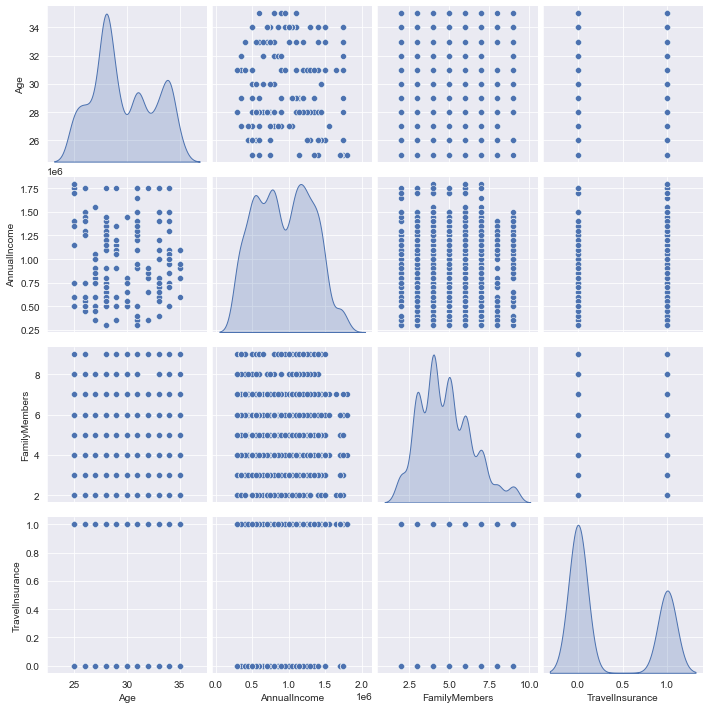

In [12]:
sns.pairplot(raw_data, diag_kind='kde')


Looking at the output of our pairplot, there isn't a clear correlation between the features in our dataset.
To confirm this, we will plot the heatmap of the correlation coefficient.

<AxesSubplot:>

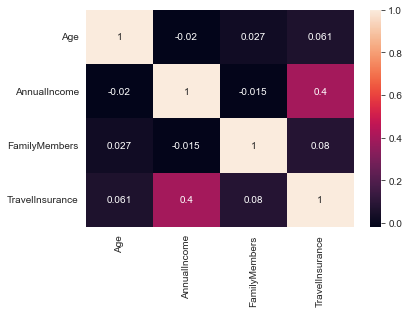

In [13]:
corrcoef = raw_data.corr()
sns.heatmap(corrcoef, annot=True)

We can confirm there is a weak correlation amongst the features in the dataset. Although, `AnnualIncome` has a weak positive correlation with an individual getting a `TravelInsurance`.

Next, we find correlation between our categorical variables and `TravelInsurance` using the Ordianry Lesat Square method and ANOVA.
Our null hypothesis is that the categorial variables and `TravelInsurance` are not correlated.

In [14]:
cat_cols = raw_data.select_dtypes('category')

anova_list = []

for col in cat_cols:
    model = ols('TravelInsurance' + '~' + col, data=raw_data).fit()
    anova = sm.stats.anova_lm(model, robust='hc3')
    anova_list.append(anova)

pd.concat(anova_list)

,df,sum_sq,mean_sq,F,PR(>F)
GraduateOrNot,1.0,0.163574,0.163574,0.711834,3.989372e-01
Residual,1985.0,456.137382,0.229792,NaN,NaN
ChronicDiseases,1.0,0.150973,0.150973,0.656978,4.177259e-01
Residual,1985.0,456.149984,0.229798,NaN,NaN
FrequentFlyer,1.0,24.581772,24.581772,113.024434,1.032551e-25
Residual,1985.0,431.719185,0.217491,NaN,NaN
EverTravelledAbroad,1.0,85.623571,85.623571,458.519444,1.088979e-91
Residual,1985.0,370.677385,0.186739,NaN,NaN
EmploymentType,1.0,9.974148,9.974148,44.359162,3.527704e-11
Residual,1985.0,446.326809,0.224850,NaN,NaN


From the statistical test above, the features ```GraduateOrNot``` and ```ChronicDiseases``` have p-values greater than 0.05 (0.399, 0.418 respectively). Hence, the null hypothesis is accepted due to p-value not statistically significant.

However, features ```FrequentFlyer```, ```EverTravelledAbroad```, ```EmploymentType``` and ```IncomeBands``` have p-values less than 0.05. Hence, the null hypothesis is rejected due to p-value statistically significant.

In [15]:
is_customer = raw_data[raw_data['TravelInsurance']==1]
not_customer = raw_data[raw_data['TravelInsurance']==0]

print("Percentage of travelers that have insurance is {}%.".format(round((len(is_customer) / len(raw_data) * 100), 2)))
print("Percentage of travelers that don't have insurance is {}%.".format(round((len(not_customer) / len(raw_data) * 100), 2)))

Percentage of travelers that have insurance is 35.73%.
Percentage of travelers that don't have insurance is 64.27%.


## 3. Data Visualization

##### Age Distribution

Text(0.5, 1.0, 'Age Distribution of all Customers')

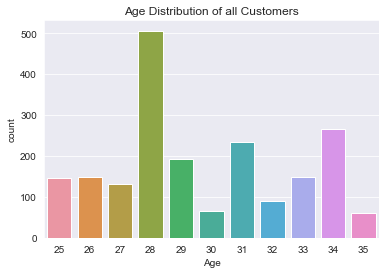

In [16]:
sns.countplot(data=raw_data, x='Age')
plt.title('Age Distribution of all Customers')

Text(0.5, 0.98, 'Age Distribution of Customers per Travel Insurance')

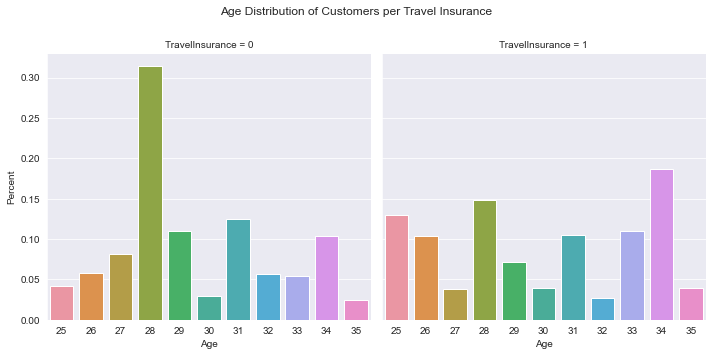

In [17]:
c = (raw_data
.groupby('TravelInsurance')['Age']
.value_counts(normalize=True)
.rename('Percent')
.reset_index()
.pipe((sns.catplot, 'data'), x='Age', y='Percent', kind='bar', col='TravelInsurance'))

c.fig.subplots_adjust(top=.85)
c.fig.suptitle('Age Distribution of Customers per Travel Insurance')

<AxesSubplot:xlabel='Age', ylabel='AnnualIncome'>

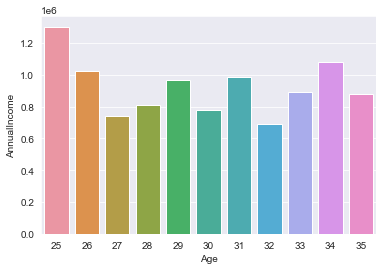

In [18]:
(raw_data
.groupby(['Age'])['AnnualIncome']
.mean()
.reset_index()
.pipe((sns.barplot, 'data'), x='Age', y='AnnualIncome')
)

Text(0.5, 0.98, 'Customers Age-Income Distribution per Travel Insurance')

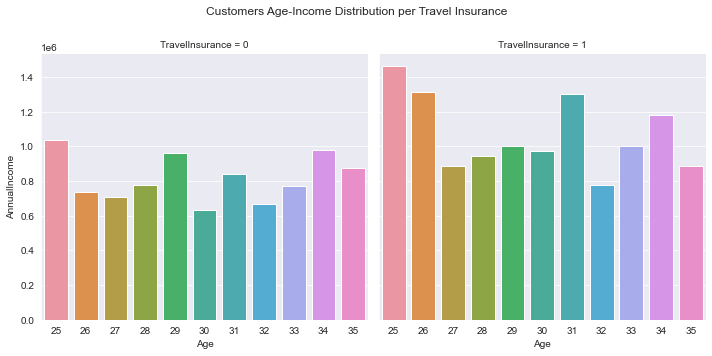

In [19]:
c = (raw_data
.groupby(['Age', 'TravelInsurance'])['AnnualIncome']
.mean()
.reset_index()
.pipe((sns.catplot, 'data'), x='Age', y='AnnualIncome', kind='bar', col='TravelInsurance'))

c.fig.subplots_adjust(top=.85)
c.fig.suptitle('Customers Age-Income Distribution per Travel Insurance')

From the above chart, it can be clearly seen that customers with `TravelInsurance` generally have higher `AnnualIncome` across all `Ages`.

In [20]:
print('The mean annual income of customers with insurance is {}'.format(round(is_customer['AnnualIncome'].mean(), 2)))
print('The mean annual income of customers with no insurance is {}'.format(round(not_customer['AnnualIncome'].mean(), 2)))

The mean annual income of customers with insurance is 1133239.44
The mean annual income of customers with no insurance is 821299.92


##### Employment Type

Text(0.5, 1.0, 'Employment Type of Customers')

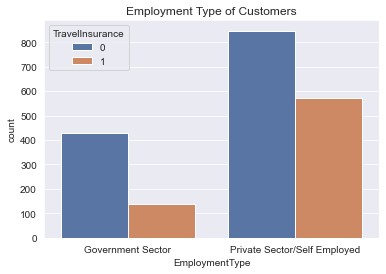

In [21]:
sns.countplot(x = 'EmploymentType', data = raw_data, hue='TravelInsurance')

plt.title('Employment Type of Customers')

Text(0.5, 0.98, "Customers' Age-Income Distribution per Employment Type")

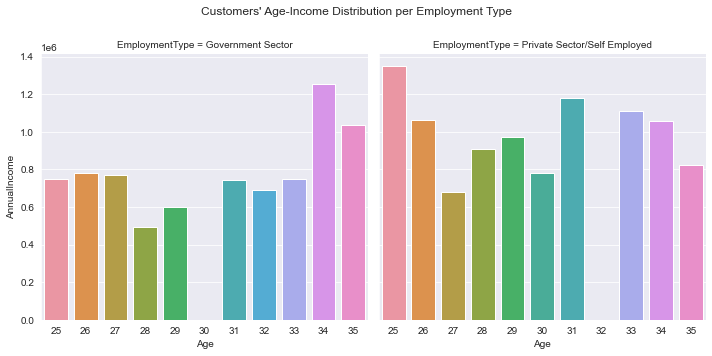

In [22]:
c = (raw_data
.groupby(['Age', 'EmploymentType'])['AnnualIncome']
.mean()
.reset_index()
.pipe((sns.catplot, 'data'), x='Age', y='AnnualIncome', kind='bar', col='EmploymentType'))

c.fig.subplots_adjust(top=.85)
c.fig.suptitle("Customers' Age-Income Distribution per Employment Type")

Customers in the Private Sector or Self Employed tend to have higher annual income than customers in Government Sector.

##### GraduateOrNot

<AxesSubplot:xlabel='GraduateOrNot', ylabel='count'>

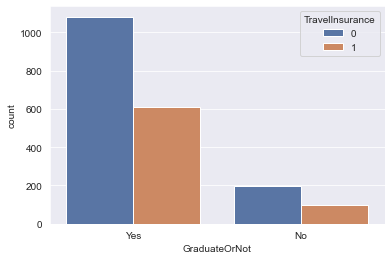

In [23]:
sns.countplot(x = 'GraduateOrNot', data = raw_data, hue='TravelInsurance', order=['Yes', 'No'])

Text(0.5, 0.98, "Customers' Age-Income Distribution per Graduation Status")

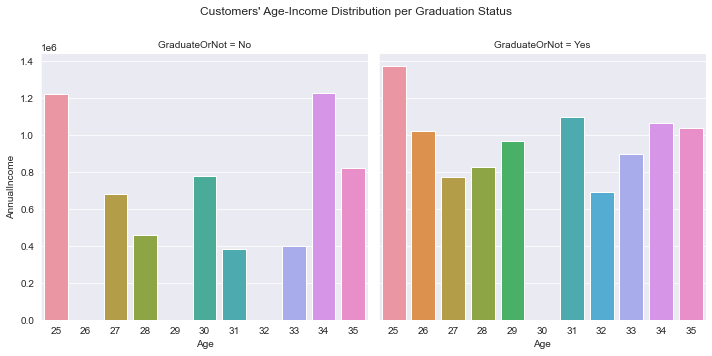

In [24]:
c = (raw_data
.groupby(['Age', 'GraduateOrNot'])['AnnualIncome']
.mean()
.reset_index()
.pipe((sns.catplot, 'data'), x='Age', y='AnnualIncome', kind='bar', col='GraduateOrNot'))

c.fig.subplots_adjust(top=.85)
c.fig.suptitle("Customers' Age-Income Distribution per Graduation Status")

Customers with university degrees tend to have an higher annual income.

##### Chronic Disease

<AxesSubplot:xlabel='ChronicDiseases', ylabel='count'>

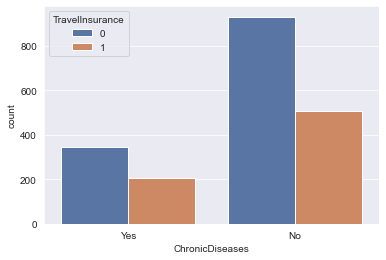

In [25]:
sns.countplot(x = 'ChronicDiseases', data = raw_data, hue='TravelInsurance', order=['Yes', 'No'])

Text(0.5, 0.98, "Customers' Age-Income Distribution per Chronic Disease")

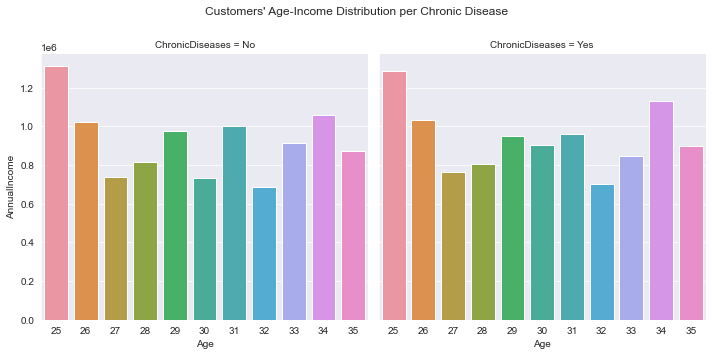

In [26]:
c = (raw_data
.groupby(['Age', 'ChronicDiseases'])['AnnualIncome']
.mean()
.reset_index()
.pipe((sns.catplot, 'data'), x='Age', y='AnnualIncome', kind='bar', col='ChronicDiseases'))

c.fig.subplots_adjust(top=.85)
c.fig.suptitle("Customers' Age-Income Distribution per Chronic Disease")

In the above chart, there isn't much contrast as to the annual income of customers with chronic disease or not.

<AxesSubplot:xlabel='ChronicDiseases', ylabel='count'>

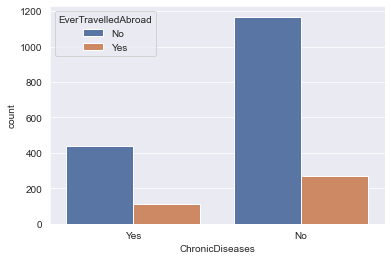

In [27]:
sns.countplot(x = 'ChronicDiseases', data = raw_data, hue='EverTravelledAbroad', order=['Yes', 'No'])

##### Frequent Flyers

<AxesSubplot:xlabel='FrequentFlyer', ylabel='count'>

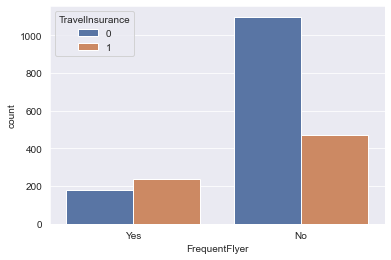

In [28]:
sns.countplot(x = 'FrequentFlyer', data = raw_data, hue='TravelInsurance', order=['Yes', 'No'])

<AxesSubplot:xlabel='FrequentFlyer', ylabel='count'>

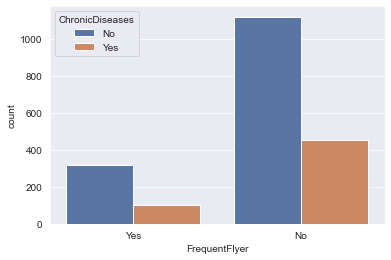

In [29]:
sns.countplot(x = 'FrequentFlyer', data = raw_data, hue='ChronicDiseases', order=['Yes', 'No'])

<AxesSubplot:xlabel='FrequentFlyer', ylabel='count'>

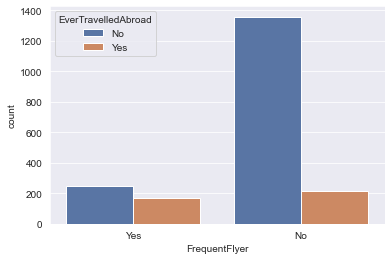

In [30]:
sns.countplot(x = 'FrequentFlyer', data = raw_data, hue='EverTravelledAbroad', order=['Yes', 'No'])

Text(0.5, 0.98, "Customers' Age-Income Distribution per Frequent Flyer")

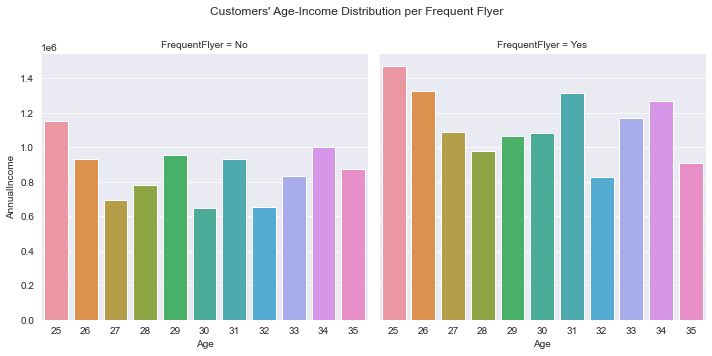

In [31]:
c = (raw_data
.groupby(['Age', 'FrequentFlyer'])['AnnualIncome']
.mean()
.reset_index()
.pipe((sns.catplot, 'data'), x='Age', y='AnnualIncome', kind='bar', col='FrequentFlyer'))

c.fig.subplots_adjust(top=.85)
c.fig.suptitle("Customers' Age-Income Distribution per Frequent Flyer")

Customers that are Frequent Flyers have higher annual income.

##### Annual Income

<AxesSubplot:xlabel='AnnualIncome', ylabel='Count'>

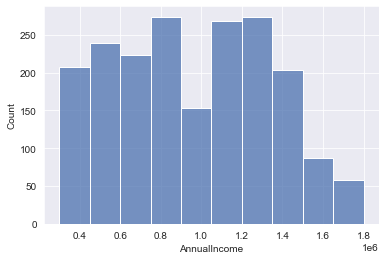

In [32]:
sns.histplot(data=raw_data, x='AnnualIncome', bins=10)

<AxesSubplot:xlabel='AnnualIncome', ylabel='Count'>

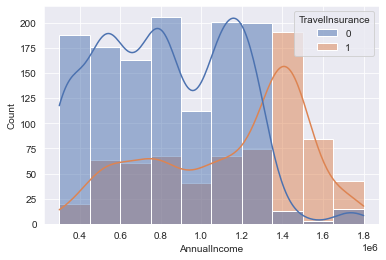

In [33]:
sns.histplot(data=raw_data, x='AnnualIncome', kde=True, hue='TravelInsurance', bins=10)

<AxesSubplot:>

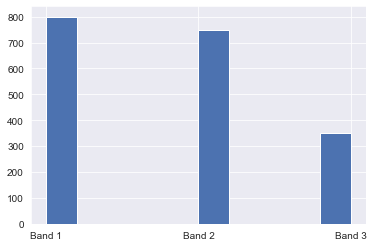

In [34]:
raw_data.IncomeBands.hist()

From our result, we can see that approximately 82% of individuals earn below 130,000 annually.

In [35]:
raw_data.groupby(['TravelInsurance', 'IncomeBands'])['AnnualIncome'].agg({'sum', 'mean'})

mean        sum
TravelInsurance IncomeBands                         
0               Band 1       5.978654e+05  364100000
                Band 2       1.101712e+06  611450000
                Band 3       1.569355e+06   48650000
1               Band 1       6.277487e+05  119900000
                Band 2       1.108462e+06  216150000
                Band 3       1.467767e+06  466750000

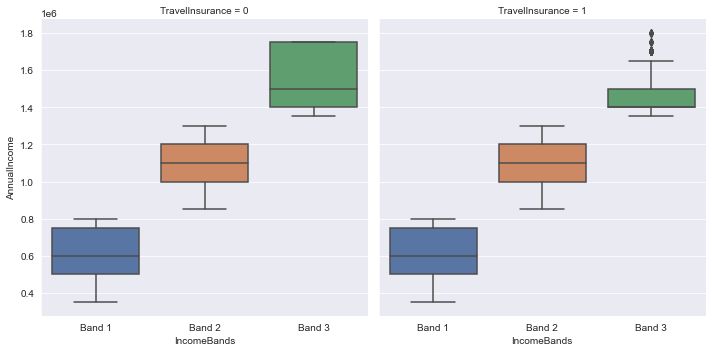

In [36]:
sns.catplot(data=raw_data, x="IncomeBands", y='AnnualIncome', kind='box', col='TravelInsurance')

From the above chart, the distribution of AnnualIncome on TravelInsurance is almost equal for all IncomeBands

In [37]:
raw_data.groupby('TravelInsurance')['IncomeBands'].value_counts(normalize=True)

TravelInsurance        
0                Band 1    0.509623
                 Band 2    0.464435
                 Band 3    0.025941
1                Band 3    0.451705
                 Band 2    0.276989
                 Band 1    0.271307
Name: IncomeBands, dtype: float64

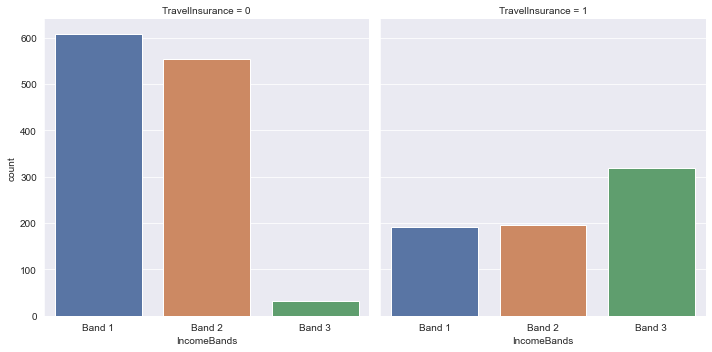

In [38]:
sns.catplot(data=raw_data, x="IncomeBands", kind='count', col='TravelInsurance')

From the above chart, individuals who have travel insurance can be found more in Income Band 3, accounting to 45% of total individuals with insurance.
However, 2.6% of those without insurance are in Income Band 3. This is intriguing because based on annual income, individual in this band can afford the insurance.
Let's dive more as to why they don't buy travel insurance.

In [39]:
raw_data.ChronicDiseases.value_counts()

No     1435
Yes     552
Name: ChronicDiseases, dtype: int64

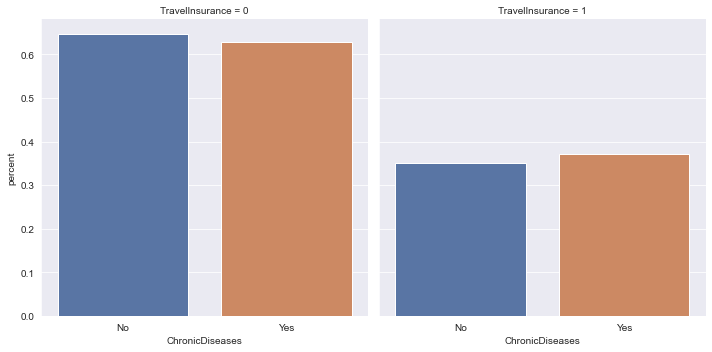

In [40]:
(raw_data
.groupby('ChronicDiseases')['TravelInsurance']
.value_counts(normalize=True)
.rename('percent')
.reset_index()
.pipe((sns.catplot, 'data'), x='ChronicDiseases', y='percent', kind='bar', col='TravelInsurance'))


In [41]:
raw_data.groupby('Employment Type')['TravelInsurance'].value_counts(normalize=True)

Employment Type               TravelInsurance
Government Sector             0                  0.754386
                              1                  0.245614
Private Sector/Self Employed  0                  0.597742
                              1                  0.402258
Name: TravelInsurance, dtype: float64

In [42]:
raw_data.FrequentFlyer.value_counts()

No     1570
Yes     417
Name: FrequentFlyer, dtype: int64